<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part B: Modelling of Recovery Factor</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

###### References

1. https://www.kaggle.com/code/kkhandekar/an-introduction-to-pycaret/notebook.
2. https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec
3. https://www.dataquest.io/blog/understanding-regression-error-metrics/ 
4. https://www.analyticsvidhya.com/blog/2021/07/automl-using-pycaret-with-a-regression-use-case/
5. https://www.datacamp.com/community/tutorials/guide-for-automating-ml-workflows-using-pycaret
6. https://pycaret.readthedocs.io/en/latest/api/regression.html
7. http://www.pycaret.org/tutorials/html/REG102.html
8. https://githubhelp.com/ray-project/tune-sklearn

## Check PyCaret Version

In [1]:
from pycaret.utils import version

In [2]:
version()

'2.3.10'

#### Libraries

In [3]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes

#!pip install natsort --user
#!pip install xlrd --user
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user
#!pip install redis --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [4]:
#Receive Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
dir_name = r'C:\Users\kswaminathan\OneDrive\03_Github_Projects\SPE210769_ML_RF_Workflow'
#dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final\1_TORIS_MODEL'
filename_suffix = 'csv'

##### Read in the data 

In [5]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dftorisv2.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,120.0,320.0,600.0,14.0,40.0000,1.586,153,10.0,41.0,...,0,0,0,303,132,1,10,1,2,0.352836
1,1,160.0,100.0,160.0,18.1,35.0000,1.230,163,65.0,35.6,...,0,0,0,303,132,1,10,1,2,0.321570
2,1,160.0,100.0,300.0,15.7,51.6333,1.190,185,102.0,32.9,...,0,1,0,303,132,1,10,1,2,0.277514
3,1,80.0,350.0,1400.0,13.0,30.0000,1.230,153,3.0,35.0,...,1,1,0,303,131,1,10,1,2,0.380000
4,1,160.0,194.0,550.0,23.0,35.0000,1.380,200,450.0,27.0,...,1,1,1,302,131,7,10,1,3,0.425909


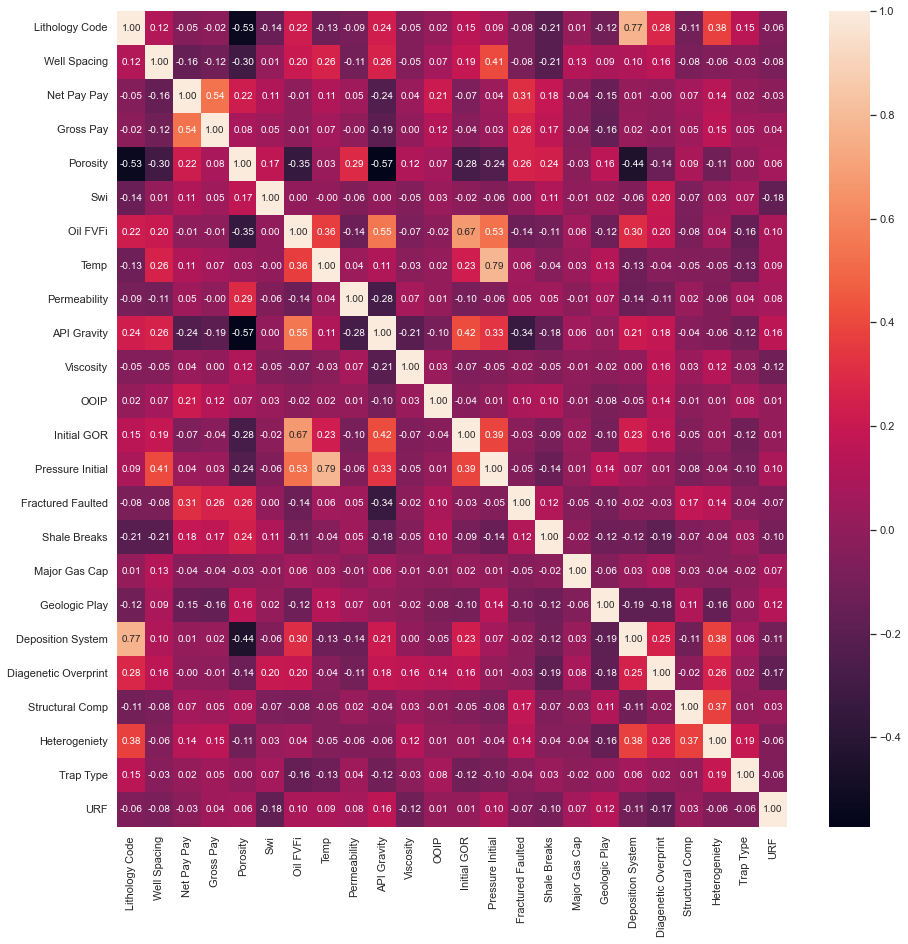

In [6]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. There was no highly correlated values

##### Convert to float - to ensure it is a numerical feature

In [7]:
df_drop = df.copy()
df_drop = df_drop[df_drop['URF']<0.51].astype(float)
df_drop = df_drop.astype(float)

# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

389
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 448
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Lithology Code        389 non-null    float64
 1   Well Spacing          389 non-null    float64
 2   Net Pay Pay           389 non-null    float64
 3   Gross Pay             389 non-null    float64
 4   Porosity              389 non-null    float64
 5   Swi                   389 non-null    float64
 6   Oil FVFi              389 non-null    float64
 7   Temp                  389 non-null    float64
 8   Permeability          389 non-null    float64
 9   API Gravity           389 non-null    float64
 10  Viscosity             389 non-null    float64
 11  OOIP                  389 non-null    float64
 12  Initial GOR           389 non-null    float64
 13  Pressure Initial      389 non-null    float64
 14  Fractured Faulted     389 non-null    float64
 15  Shale Breaks       

Final Data set has 389 rows and 24 columns.

### Train, Validation, and Test Split

In [8]:
# Creates a mask where values that are true go into the training/test set
# Note that I done it so that the random number is predictable

msk = np.random.seed(0)
msk = np.random.rand(len(df_drop))<0.8

raw_train_validate_set = df_drop[msk]
raw_test_set = df_drop[~msk]

print(raw_train_validate_set.shape)
print(raw_test_set.shape)

(317, 24)
(72, 24)


In [9]:
raw_train_validate_set.to_excel(r'dfssoil.xlsx', index = False, header=True)
raw_test_set.to_excel(r'BlindTest_SSOIL.xlsx', index = False, header=True)

We split the data set 80-20 into a "train-validate" set and a "test" set. The test set is external asn will never be seen by the model.

## 1. Pycaret Implementation

Pycaret will be used in the machine learning portion. Pycaret is a low-code machine learning library in Python that automates machine learning workflows. One of its key benefits is its ability to run a large number of differnt machine learning algorithms, but with only a few lines of code

In [10]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfssoil.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,120.0,320.0,600.0,14.0,40.0000,1.586,153,10.0,41.0,...,0,0,0,303,132,1,10,1,2,0.352836
1,1,160.0,100.0,160.0,18.1,35.0000,1.230,163,65.0,35.6,...,0,0,0,303,132,1,10,1,2,0.321570
2,1,160.0,100.0,300.0,15.7,51.6333,1.190,185,102.0,32.9,...,0,1,0,303,132,1,10,1,2,0.277514
3,1,80.0,350.0,1400.0,13.0,30.0000,1.230,153,3.0,35.0,...,1,1,0,303,131,1,10,1,2,0.380000
4,1,160.0,194.0,550.0,23.0,35.0000,1.380,200,450.0,27.0,...,1,1,1,302,131,7,10,1,3,0.425909


In [11]:
from pycaret.regression import *

#Create a copy
model_df = df_drop.copy()
target = 'URF'

# no resampling
clf_none = setup(
            data=model_df,
            target=target,
            session_id=42,
            normalize=True,
            transformation = True,
            ignore_low_variance=True,
            remove_outliers = True, #outliers_threshold = 0.1,
            #remove_multicollinearity = True, multicollinearity_threshold = 0.6,
            train_size=0.7)

,Description,Value
0,session_id,42
1,Target,URF
2,Original Data,"(389, 24)"
3,Missing Values,False
4,Numeric Features,21
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(258, 23)"


In [12]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0791,0.0096,0.0976,0.0949,0.0754,0.3462,0.1570
ada,AdaBoost Regressor,0.0813,0.0100,0.0994,0.0741,0.0768,0.3650,0.0290
et,Extra Trees Regressor,0.0788,0.0100,0.0993,0.0608,0.0766,0.3430,0.1070
br,Bayesian Ridge,0.0820,0.0101,0.1001,0.0558,0.0774,0.3669,0.0080
catboost,CatBoost Regressor,0.0821,0.0104,0.1015,0.0202,0.0782,0.3553,1.0970
omp,Orthogonal Matching Pursuit,0.0840,0.0106,0.1024,0.0115,0.0793,0.3766,0.0070
ridge,Ridge Regression,0.0829,0.0107,0.1027,-0.0079,0.0795,0.3626,0.0080
lr,Linear Regression,0.0830,0.0107,0.1029,-0.0120,0.0797,0.3629,0.7700
lar,Least Angle Regression,0.0830,0.0107,0.1029,-0.0120,0.0797,0.3629,0.0090
knn,K Neighbors Regressor,0.0830,0.0109,0.1037,-0.0153,0.0801,0.3675,0.0180


In [13]:
top3_fold_5 = compare_models(include=['rf', 'catboost', 'knn'], fold = 5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0799,0.0098,0.0989,0.0938,0.0762,0.3427,1.0720
rf,Random Forest Regressor,0.0805,0.0098,0.0988,0.0971,0.0763,0.3512,0.1920
knn,K Neighbors Regressor,0.0841,0.0113,0.1063,-0.0442,0.0820,0.3690,0.0160


In [14]:
top3 = compare_models(include=['rf', 'catboost', 'knn'], fold = 10, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0791,0.0096,0.0976,0.0949,0.0754,0.3462,0.0770
catboost,CatBoost Regressor,0.0821,0.0104,0.1015,0.0202,0.0782,0.3553,0.7880
knn,K Neighbors Regressor,0.0830,0.0109,0.1037,-0.0153,0.0801,0.3675,0.0340


There is a performance improvement in going from 5 folds to 10 folds for all 3 models. To keep computation time reasonable, folds is kept at 10.

## 2. Plot each Model and Check Features

##### Random Forest (RFR)

In [15]:
rfr = create_model('rf')
rfr_results = pull()

rfr_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(rfr.feature_importances_)}).sort_values(by='Value', ascending=False)
rfr_feature_imp.to_csv('Feature_importance_RFR.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0661,0.0064,0.0797,0.3402,0.0610,0.2549
1,0.0760,0.0089,0.0941,0.2115,0.0715,0.2832
2,0.0917,0.0114,0.1067,0.0191,0.0836,0.4631
3,0.0834,0.0120,0.1096,-0.3423,0.0826,0.2588
4,0.0671,0.0079,0.0891,0.3035,0.0708,0.3988
5,0.0910,0.0121,0.1099,-0.0062,0.0851,0.4065
6,0.0909,0.0116,0.1078,0.0844,0.0826,0.3727
7,0.0812,0.0095,0.0973,0.0498,0.0744,0.3231
8,0.0742,0.0089,0.0941,0.2769,0.0744,0.4332


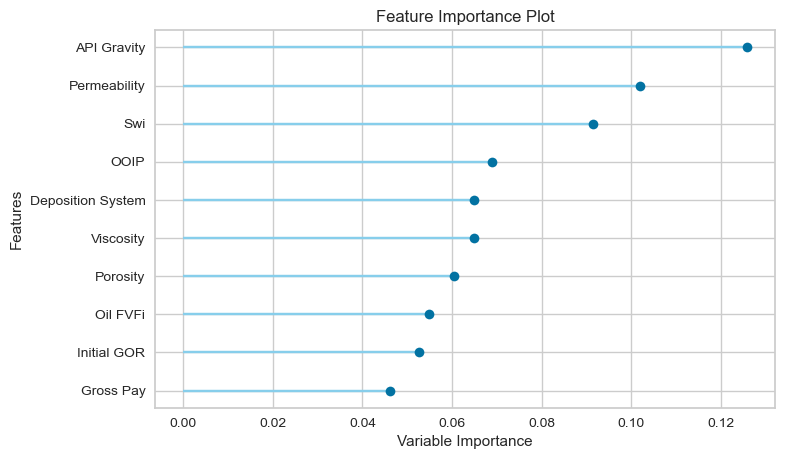

In [16]:
plot_model(rfr, plot = 'feature')

##### Catboost Regressor (catboost)

In [17]:
cb = create_model('catboost')
cb_results = pull()
#print(gbr_results)

cb_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(cb.feature_importances_)}).sort_values(by='Value', ascending=False)
cb_feature_imp.to_csv('Feature_importance_CatBoost.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0703,0.0071,0.0843,0.2620,0.0646,0.2723
1,0.0811,0.0097,0.0987,0.1338,0.0749,0.2963
2,0.0993,0.0129,0.1134,-0.1079,0.0887,0.4943
3,0.0865,0.0124,0.1114,-0.3870,0.0839,0.2577
4,0.0641,0.0072,0.0848,0.3689,0.0678,0.3853
5,0.0951,0.0133,0.1152,-0.1057,0.0888,0.4199
6,0.0950,0.0129,0.1135,-0.0160,0.0869,0.3881
7,0.0852,0.0112,0.1056,-0.1197,0.0811,0.3445
8,0.0746,0.0091,0.0951,0.2606,0.0750,0.4311


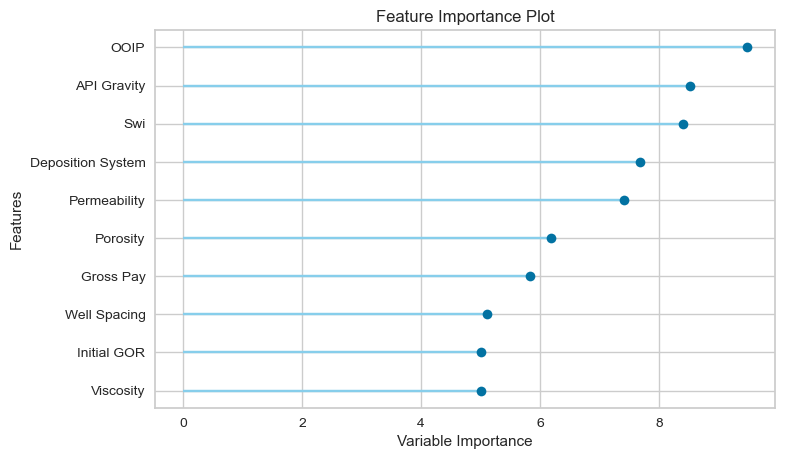

In [18]:
plot_model(cb, plot = 'feature')

##### Gradient Boost Regressor (gbr)

In [19]:
gbr = create_model('gbr')
gbr_results = pull()
#print(cb_results)

gbr_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(gbr.feature_importances_)}).sort_values(by='Value', ascending=False)
gbr_feature_imp.to_csv('Feature_importance_GBR.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0783,0.0083,0.0912,0.1360,0.0700,0.2982
1,0.0821,0.0100,0.1000,0.1101,0.0762,0.3089
2,0.1063,0.0152,0.1233,-0.3092,0.0956,0.5189
3,0.0920,0.0135,0.1164,-0.5147,0.0879,0.2851
4,0.0647,0.0076,0.0869,0.3373,0.0685,0.3725
5,0.0920,0.0125,0.1118,-0.0413,0.0862,0.3989
6,0.0923,0.0126,0.1123,0.0059,0.0855,0.3506
7,0.0840,0.0104,0.1019,-0.0431,0.0779,0.3273
8,0.0802,0.0104,0.1022,0.1471,0.0805,0.4519


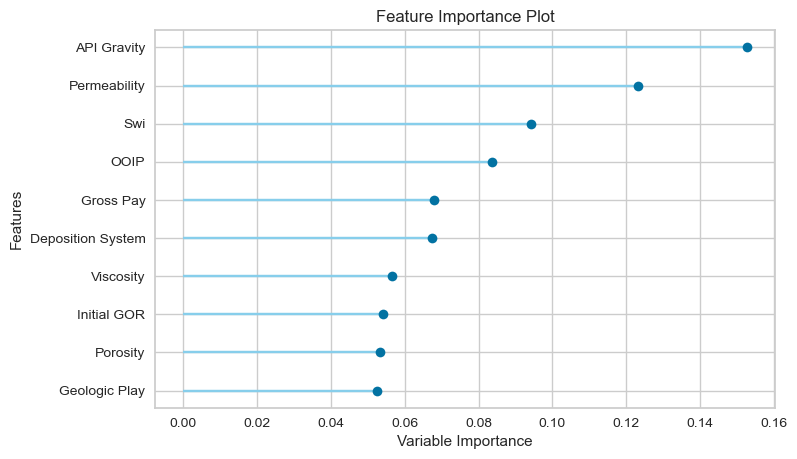

In [20]:
# Given the sheer number of variables, will only plot the first 10
# 'feature_all' will plot everything
plot_model(gbr, plot = 'feature')

### KNN Model - note that it does not support feature importance

In [21]:
knn = create_model('knn')
knn_results = pull()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0718,0.0083,0.0912,0.1357,0.0696,0.2595
1,0.0962,0.0128,0.1132,-0.1411,0.0863,0.3662
2,0.0866,0.0106,0.1029,0.0881,0.0816,0.4714
3,0.0899,0.0126,0.1121,-0.4045,0.0836,0.2763
4,0.0733,0.0087,0.0934,0.2340,0.0746,0.4272
5,0.0887,0.0134,0.1159,-0.1180,0.0892,0.3922
6,0.0914,0.0116,0.1077,0.0856,0.0833,0.4003
7,0.0869,0.0123,0.1107,-0.2310,0.0845,0.3399
8,0.0862,0.0113,0.1064,0.0749,0.0844,0.5078


## 3a. Testing for Optimisation - Not necessary to run
-----------------------------------------------------------------------------------

One of the important parameters in the hyperparameters is the number of iterations over which the K fold cross validation is done. 

2 checks are done for this. The first scenario is over the range(0, 1000, 50). The optimisation ran overnight and showed that the ML algorithm did not see much improvement past 50.

In [22]:
# elapsed = []
# MAE_mean_iter = []
# MSE_mean_iter = []
# RMSE_mean_iter = []

# # The output from the (0, 1000, 50) is saved; there is no need to run this again. 
# # Line has been modified just so the code can run.
# for i in range(0, 51, 50):
#     start = time.time()
#     if i == 0:
#         i += 1    
#     tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = i)
#     #print(tuned_cb)
#     MAE_mean_iter.append(pull()['MAE']['Mean'])
#     MSE_mean_iter.append(pull()['MSE']['Mean'])
#     RMSE_mean_iter.append(pull()['RMSE']['Mean'])
#     elapsed.append((time.time() - start))

# MAE_Mean = pd.DataFrame(MAE_mean_iter, index = elapsed, columns=['MAE Mean Error'])
# MAE_Mean.index.name = 'Elapsed Time'

# MSE_Mean = pd.DataFrame(MSE_mean_iter, index = elapsed, columns=['MSE Mean Error']) 
# MSE_Mean.index.name = 'Elapsed Time'

# RMSE_Mean = pd.DataFrame(RMSE_mean_iter, index = elapsed, columns=['RMSE Mean Error'])
# RMSE_Mean.index.name = 'Elapsed Time'

# res_50_iter = pd.concat([MAE_Mean, MSE_Mean, RMSE_Mean], axis=1)

# print(res_50_iter)

In [23]:
# b = sns.lineplot(data=res_50_iter)
# b.axes.set_title("Error as function of Elapsed Time",fontsize=20)
# b.set_xlabel("Elapsed Time",fontsize=20)
# b.set_ylabel("Error",fontsize=20)
# #b.set_yscale('log')
# b.tick_params(labelsize=18)

In [24]:
#res.to_csv('Run_Catboost_1000_Itr.csv')

In [25]:
# elapsed = []
# MAE_mean_iter = []
# MSE_mean_iter = []
# RMSE_mean_iter = []

# # This was run at (1, 51, 1) to get increments of 1
# # Right now, this is changed to (1, 51, 50) to allow the code to run efficiently
# for i in range(1, 51, 50):
#     start = time.time()
#     tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = i)
#     MAE_mean_iter.append(pull()['MAE']['Mean'])
#     MSE_mean_iter.append(pull()['MSE']['Mean'])
#     RMSE_mean_iter.append(pull()['RMSE']['Mean'])
#     elapsed.append((time.time() - start))

# MAE_Mean = pd.DataFrame(MAE_mean_iter, index = elapsed, columns=['MAE Mean Error'])
# MAE_Mean.index.name = 'Elapsed Time'

# MSE_Mean = pd.DataFrame(MSE_mean_iter, index = elapsed, columns=['MSE Mean Error']) 
# MSE_Mean.index.name = 'Elapsed Time'

# RMSE_Mean = pd.DataFrame(RMSE_mean_iter, index = elapsed, columns=['RMSE Mean Error'])
# RMSE_Mean.index.name = 'Elapsed Time'

# res_1_iter = pd.concat([MAE_Mean, MSE_Mean, RMSE_Mean], axis=1)

# print(res_1_iter)

# res_1_iter.to_csv('Run_Catboost_50_Itr.csv')

In [26]:
# b = sns.lineplot(data=res_1_iter)
# b.axes.set_title("Error as function of Elapsed Time",fontsize=20)
# b.set_xlabel("Elapsed Time",fontsize=20)
# b.set_ylabel("Error",fontsize=20)
# #b.set_yscale('log')
# b.tick_params(labelsize=18)

In [27]:
# tuned_cb3 = tune_model(cb, optimize = 'RMSE', n_iter = 10)

In [28]:
# plot_model(tuned_cb3, plot = 'parameter')

##### Gradient Boosting Regression

In [29]:
# gbr = create_model('gbr')
# print(gbr)

In [30]:
# tuned_gbr = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=50)
# print(tuned_gbr)

----------------------------------------------------------------------------------------------------------------------------

## 3. Optimisation

### a. Tune the Model

The earlier experiments allow one to determine which model performs efficiently, and the tuning needed to arrive at the answer. Here, we will create the 3 specific models , which we will than blend, and than finally produce a "tuned" blended model based on earlier optimised parameters

from pycaret.distributions import UniformDistribution, CategoricalDistribution

catboost_param_dists = {
    'iterations': CategoricalDistribution([500,100,300]),
    'colsample_bylevel': UniformDistribution(0.5, 1.0),
    'random_strength': CategoricalDistribution([0,0.1,0.2,1,10]),
    'max_depth' : CategoricalDistribution([5,6,7,8,9])
}

In [31]:
tuned_models = []

In [32]:
rf = create_model('rf', fold = 10)
# rf = tune_model(rf, 
#                 optimize = 'RMSE', 
#                 n_iter = 50, 
#                 choose_better = True, 
#                  #search_library = "tune-sklearn", 
#                  #search_algorithm="Hyperopt",
#                  #search_algorithm="Optuna",
#                  #search_algorithm="bayesian",
#                 )
tuned_models.append(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0661,0.0064,0.0797,0.3402,0.0610,0.2549
1,0.0760,0.0089,0.0941,0.2115,0.0715,0.2832
2,0.0917,0.0114,0.1067,0.0191,0.0836,0.4631
3,0.0834,0.0120,0.1096,-0.3423,0.0826,0.2588
4,0.0671,0.0079,0.0891,0.3035,0.0708,0.3988
5,0.0910,0.0121,0.1099,-0.0062,0.0851,0.4065
6,0.0909,0.0116,0.1078,0.0844,0.0826,0.3727
7,0.0812,0.0095,0.0973,0.0498,0.0744,0.3231
8,0.0742,0.0089,0.0941,0.2769,0.0744,0.4332


In [33]:
cb = create_model('catboost', fold = 10)
# cb = tune_model(cb, 
#                 optimize = 'RMSE', 
#                 n_iter = 50, 
#                 choose_better = True,
#                 #search_library = "optuna", 
#                 #search_library = "tune-sklearn", 
#                 #search_algorithm="bayesian",
#                 #search_algorithm="hyperopt",
#                 #custom_grid = catboost_param_dists ,
#                 #early_stopping = "asha",
#                 #early_stopping_max_iters = 10,
#                 #return_tuner = False ,   
#                )
tuned_models.append(cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0703,0.0071,0.0843,0.2620,0.0646,0.2723
1,0.0811,0.0097,0.0987,0.1338,0.0749,0.2963
2,0.0993,0.0129,0.1134,-0.1079,0.0887,0.4943
3,0.0865,0.0124,0.1114,-0.3870,0.0839,0.2577
4,0.0641,0.0072,0.0848,0.3689,0.0678,0.3853
5,0.0951,0.0133,0.1152,-0.1057,0.0888,0.4199
6,0.0950,0.0129,0.1135,-0.0160,0.0869,0.3881
7,0.0852,0.0112,0.1056,-0.1197,0.0811,0.3445
8,0.0746,0.0091,0.0951,0.2606,0.0750,0.4311


In [34]:
knn = create_model('knn', fold = 10)
# knn = tune_model(knn, 
#                  optimize = 'R2', 
#                  n_iter = 300, 
#                  choose_better = True, 
#                  #search_library = "tune-sklearn", 
#                  #search_algorithm="Hyperopt",
#                  #search_algorithm="Optuna",
#                  #search_algorithm="bayesian",
#                 )
tuned_models.append(knn)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0718,0.0083,0.0912,0.1357,0.0696,0.2595
1,0.0962,0.0128,0.1132,-0.1411,0.0863,0.3662
2,0.0866,0.0106,0.1029,0.0881,0.0816,0.4714
3,0.0899,0.0126,0.1121,-0.4045,0.0836,0.2763
4,0.0733,0.0087,0.0934,0.2340,0.0746,0.4272
5,0.0887,0.0134,0.1159,-0.1180,0.0892,0.3922
6,0.0914,0.0116,0.1077,0.0856,0.0833,0.4003
7,0.0869,0.0123,0.1107,-0.2310,0.0845,0.3399
8,0.0862,0.0113,0.1064,0.0749,0.0844,0.5078


### b. Ensemble the Model

pycaret.regression.ensemble_model(estimator, method: str = 'Bagging', fold: Optional[Union[int, Any]] = None, n_estimators: int = 10, round: int = 4, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False)

In [35]:
prediction_model = []

In [36]:
tuned_bagged_rf = ensemble_model(estimator = rf, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0708,0.0071,0.0841,0.2644,0.0645,0.2729
1,0.0779,0.0090,0.0947,0.2014,0.0721,0.2938
2,0.0879,0.0105,0.1023,0.0992,0.0805,0.4508
3,0.0795,0.0102,0.1009,-0.1383,0.0753,0.2449
4,0.0691,0.0082,0.0905,0.2815,0.0722,0.4142
5,0.0915,0.0117,0.1082,0.0249,0.0838,0.4054
6,0.0913,0.0111,0.1052,0.1279,0.0809,0.3849
7,0.0765,0.0088,0.0939,0.1146,0.0720,0.3113
8,0.0741,0.0091,0.0954,0.2558,0.0755,0.4494


In [37]:
tuned_boosted_rf = ensemble_model(estimator = rf, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0693,0.0070,0.0835,0.2762,0.0639,0.2671
1,0.0805,0.0098,0.0988,0.1309,0.0752,0.3022
2,0.0856,0.0106,0.1030,0.0858,0.0811,0.4463
3,0.0817,0.0114,0.1066,-0.2703,0.0797,0.2457
4,0.0708,0.0084,0.0916,0.2637,0.0727,0.4155
5,0.0909,0.0119,0.1091,0.0085,0.0844,0.4076
6,0.0936,0.0118,0.1087,0.0690,0.0832,0.3777
7,0.0820,0.0101,0.1003,-0.0096,0.0770,0.3373
8,0.0738,0.0089,0.0945,0.2708,0.0746,0.4377


In [38]:
tuned_bagged_cb = ensemble_model(estimator = cb, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0716,0.0073,0.0854,0.2414,0.0655,0.2775
1,0.0781,0.0089,0.0944,0.2064,0.0718,0.2913
2,0.0907,0.0111,0.1052,0.0467,0.0825,0.4586
3,0.0803,0.0107,0.1032,-0.1911,0.0771,0.2420
4,0.0680,0.0078,0.0885,0.3131,0.0707,0.4078
5,0.0929,0.0119,0.1092,0.0078,0.0844,0.4095
6,0.0936,0.0116,0.1078,0.0841,0.0830,0.3966
7,0.0814,0.0102,0.1011,-0.0259,0.0776,0.3309
8,0.0736,0.0088,0.0937,0.2824,0.0742,0.4433


In [39]:
tuned_boosted_cb = ensemble_model(estimator = cb, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0682,0.0070,0.0835,0.2763,0.0641,0.2674
1,0.0813,0.0098,0.0988,0.1312,0.0751,0.3026
2,0.0903,0.0112,0.1057,0.0379,0.0830,0.4586
3,0.0814,0.0116,0.1075,-0.2929,0.0805,0.2423
4,0.0710,0.0082,0.0905,0.2808,0.0718,0.4107
5,0.0911,0.0122,0.1104,-0.0153,0.0854,0.4096
6,0.0939,0.0119,0.1092,0.0602,0.0838,0.3892
7,0.0813,0.0102,0.1012,-0.0278,0.0777,0.3332
8,0.0715,0.0086,0.0929,0.2947,0.0735,0.4317


In [40]:
tuned_bagged_knn = ensemble_model(estimator = knn, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_knn)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0717,0.0079,0.0888,0.1801,0.0680,0.2668
1,0.0909,0.0116,0.1078,-0.0333,0.0822,0.3489
2,0.0904,0.0110,0.1047,0.0555,0.0829,0.4794
3,0.0883,0.0120,0.1096,-0.3427,0.0819,0.2700
4,0.0714,0.0084,0.0916,0.2641,0.0730,0.4155
5,0.0926,0.0131,0.1143,-0.0887,0.0880,0.4018
6,0.0932,0.0117,0.1081,0.0783,0.0837,0.4129
7,0.0848,0.0120,0.1097,-0.2070,0.0840,0.3484
8,0.0791,0.0104,0.1019,0.1512,0.0810,0.4860


In [41]:
tuned_boosted_knn = ensemble_model(estimator = knn, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_knn)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0823,0.0108,0.1040,-0.1236,0.0802,0.2917
1,0.0967,0.0151,0.1231,-0.3482,0.0941,0.3665
2,0.0781,0.0105,0.1023,0.0983,0.0804,0.4230
3,0.1168,0.0193,0.1390,-1.1592,0.1049,0.3667
4,0.0811,0.0116,0.1077,-0.0173,0.0844,0.4554
5,0.1024,0.0176,0.1328,-0.4680,0.1017,0.4460
6,0.1104,0.0179,0.1338,-0.4107,0.1028,0.4884
7,0.1062,0.0169,0.1301,-0.6983,0.1000,0.4459
8,0.0760,0.0093,0.0963,0.2428,0.0768,0.4361


### c. Blending all Models

pycaret.regression.blend_models(
estimator_list: list, fold: Optional[Union[int, Any]] = None, round: int = 4, choose_better: bool = False, optimize: str = 'R2', weights: Optional[List[float]] = None, fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False )

In [42]:
blend_5_soft = blend_models(estimator_list = tuned_models, fold=5, optimize = 'RMSE', choose_better = True)
prediction_model.append(blend_5_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0781,0.0091,0.0953,0.1300,0.0725,0.2934
1,0.0859,0.0109,0.1043,-0.0264,0.0800,0.3512
2,0.0781,0.0098,0.0992,0.1633,0.0778,0.4008
3,0.0869,0.0106,0.1029,0.0747,0.0787,0.3487
4,0.0708,0.0083,0.0911,0.1656,0.0712,0.3513
Mean,0.0800,0.0097,0.0986,0.1014,0.0761,0.3491
Std,0.0059,0.0010,0.0049,0.0718,0.0035,0.0340


In [43]:
blend_10_soft = blend_models(estimator_list = tuned_models, fold=10, optimize = 'RMSE', choose_better = True)
prediction_model.append(blend_10_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0674,0.0066,0.0812,0.3145,0.0621,0.2565
1,0.0808,0.0098,0.0989,0.1296,0.0751,0.3032
2,0.0925,0.0113,0.1062,0.0295,0.0835,0.4763
3,0.0849,0.0118,0.1085,-0.3155,0.0813,0.2585
4,0.0660,0.0074,0.0862,0.3479,0.0689,0.3967
5,0.0903,0.0123,0.1109,-0.0234,0.0856,0.4011
6,0.0924,0.0115,0.1074,0.0902,0.0826,0.3870
7,0.0822,0.0105,0.1024,-0.0520,0.0783,0.3283
8,0.0772,0.0092,0.0959,0.2489,0.0760,0.4538


### d. Stacking all Models

pycaret.regression.stack_models(estimator_list: list, meta_model=None, meta_model_fold: Optional[Union[int, Any]] = 5, fold: Optional[Union[int, Any]] = None, round: int = 4, restack: bool = True, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False)

In [44]:
stack_5 = stack_models(estimator_list = tuned_models, meta_model = rf, fold = 5, optimize = 'RMSE', choose_better= True)
prediction_model.append(stack_5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0768,0.0081,0.0901,0.2214,0.0688,0.2894
1,0.0832,0.0111,0.1052,-0.0440,0.0806,0.3313
2,0.0799,0.0100,0.0998,0.1532,0.0785,0.4126
3,0.0854,0.0102,0.1009,0.1113,0.0774,0.3473
4,0.0794,0.0098,0.0991,0.0125,0.0772,0.3819
Mean,0.0809,0.0098,0.0990,0.0909,0.0765,0.3525
Std,0.0030,0.0010,0.0049,0.0956,0.0040,0.0423


In [45]:
stack_10 = stack_models(estimator_list = tuned_models, meta_model = rf, fold = 10, optimize = 'RMSE', choose_better= True)
prediction_model.append(stack_10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0692,0.0072,0.0849,0.2513,0.0650,0.2692
1,0.0779,0.0091,0.0956,0.1874,0.0729,0.3005
2,0.0968,0.0124,0.1113,-0.0660,0.0870,0.4730
3,0.0873,0.0129,0.1138,-0.4472,0.0857,0.2696
4,0.0706,0.0087,0.0935,0.2328,0.0742,0.4158
5,0.0900,0.0119,0.1089,0.0132,0.0844,0.4038
6,0.0979,0.0129,0.1135,-0.0154,0.0871,0.4048
7,0.0798,0.0097,0.0984,0.0275,0.0753,0.3209
8,0.0782,0.0109,0.1042,0.1133,0.0823,0.4721


In [46]:
prediction_model

[BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                    

In [47]:
for model in prediction_model:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0756,0.0088,0.0939,0.0731,0.0717,0.2888


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.317442
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.366053
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.376413
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.353762
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.321347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.281444
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.324875
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.326011
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.347356


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0765,0.0092,0.0961,0.0294,0.0734,0.2886


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.299926
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.370573
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.377053
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.382074
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.327474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.272922
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.345657
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.331925
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.353108


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0741,0.0087,0.0934,0.0829,0.0714,0.2827


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.311544
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.366552
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.366404
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.346343
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.328123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.286353
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.331204
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.329418
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.346613


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0763,0.0091,0.0955,0.0402,0.0729,0.2875


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.298203
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.377083
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.369255
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.362524
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.322922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.278617
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.331389
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.340271
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.355148


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0734,0.0082,0.0904,0.1409,0.0690,0.2806


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.284592
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.268505
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.320010
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.266568
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.359476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.313867
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.288927
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.358002
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.279678


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.0810,0.0105,0.1025,-0.1052,0.0787,0.2999


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.278658
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.247740
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.356761
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.275125
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.390727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.320200
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.368000
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.402916
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.330590


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0731,0.0084,0.0916,0.1169,0.0700,0.2770


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.297060
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.343906
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.356774
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.326659
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.330774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.290287
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.314473
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.340357
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.338607


RandomForestRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0776,0.0094,0.0970,0.0109,0.0742,0.2940


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.306572
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.385910
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.397968
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.354297
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.314230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.284198
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.331284
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.339314
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.350481


RandomForestRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0776,0.0094,0.0970,0.0109,0.0742,0.2940


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.306572
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.385910
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.397968
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.354297
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.314230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.284198
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.331284
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.339314
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.350481


RandomForestRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0776,0.0094,0.0970,0.0109,0.0742,0.2940


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.306572
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.385910
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.397968
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.354297
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.314230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.284198
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.331284
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.339314
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.350481


From the results above, the best models (largest R2) are 

1. tuned_bagged_knn
2. blend_5_soft
3. rf
4. tuned_bagged_cb

## 4. Finalise the model

In [48]:
final_blend = finalize_model(blend_5_soft)

In [49]:
final_cb = finalize_model(tuned_bagged_cb)

In [50]:
final_knn = finalize_model(tuned_bagged_knn)

In [51]:
final_rf = finalize_model(rf)

## 5. Save the Model

In [52]:
save_model(tuned_bagged_knn, 'Bagged_KNN_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='URF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                 ['trained_model',
                  BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto',
                                                                      leaf_size=30,
                                                                      metric='minkowski',
                

In [53]:
save_model(blend_5_soft, 'Blended_model_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='URF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                                                                     n_estimators=100,
                                                                     n_jobs=-1,
                                                                     oob_score=False,
                                                            

In [54]:
save_model(rf, 'Ori_rf_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='URF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=None,
                                        max_features='auto', max_leaf_nodes=None,
                                        max_samples=None,
                             

In [55]:
save_model(tuned_bagged_cb, 'Bagged_cb_15072022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='URF',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='me...
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  BaggingRegressor(base_estimator=<catboost.core.CatBoostRegressor object at 0x00000238491AC520>,
                 

### Plots to analyse Model

In [56]:
model = final_cb
predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0302,0.0015,0.0387,0.8424,0.0298,0.1176


,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,Fractured Faulted_1.0,Shale Breaks_1.0,URF,Label
0,1.278364,-0.317913,-0.570968,-0.432768,-0.615021,0.993340,-0.024870,-1.411289,-0.749942,-0.409911,...,1.741037,-0.334302,-0.771463,-0.474465,-0.734535,1.178933,0.0,0.0,0.350000,0.334544
1,1.278364,-0.588447,-0.768439,-0.925595,1.075123,0.601290,-1.321348,1.053108,1.821618,0.724202,...,0.035318,-0.614598,-0.771463,2.138044,1.658864,1.178933,1.0,0.0,0.364000,0.359698
2,-0.747858,-0.960151,1.296303,0.428715,0.882416,-0.127473,0.550279,0.467924,0.913642,-0.074383,...,1.738721,-0.845371,-0.771463,2.141050,-0.734535,-0.377217,1.0,0.0,0.500000,0.430183
3,-0.747858,-0.107985,1.752018,1.111271,1.167903,-0.019036,-0.024870,0.467924,0.592483,-0.409911,...,0.047301,-0.037963,-0.771463,2.138044,-0.734535,-0.377217,1.0,1.0,0.450000,0.408952
4,-0.747858,-0.889283,-1.074614,-0.301124,-0.312838,1.743381,-0.481701,-1.830031,-0.696673,0.724202,...,1.343638,-0.903901,-0.771463,-0.474465,-0.734535,-1.670193,0.0,1.0,0.290986,0.298761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.278364,-0.317913,-0.710625,0.314112,-0.773371,0.500965,1.665170,-0.883360,-0.859384,-0.409911,...,-1.114503,1.152146,1.014383,-0.474465,1.248278,1.178933,0.0,0.0,0.230528,0.256238
113,-0.747858,0.566416,-0.857278,0.952786,-1.450772,0.500965,1.270425,0.252225,-0.788580,0.977306,...,-0.857609,-0.557782,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.110731,0.213695
114,-0.747858,-1.541400,1.952302,1.740813,1.167903,-0.574731,0.641455,0.467924,0.508940,-0.986080,...,0.047301,-0.037963,-0.771463,-0.474465,-0.734535,-0.377217,1.0,1.0,0.400000,0.368793
115,-0.747858,-1.552588,2.059153,2.023734,0.931553,-1.158629,0.601178,1.160107,-0.437413,-0.642842,...,0.042518,-0.037963,-0.771463,2.138044,1.658864,-0.377217,0.0,1.0,0.309771,0.336468


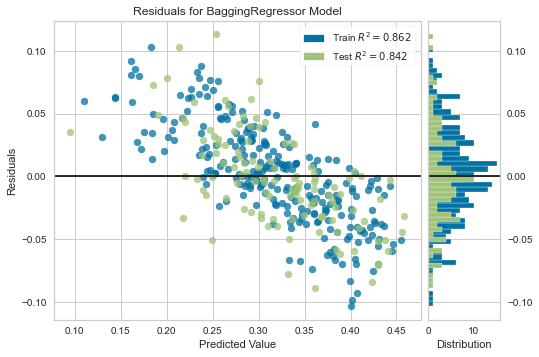

In [57]:
plot_model(model)

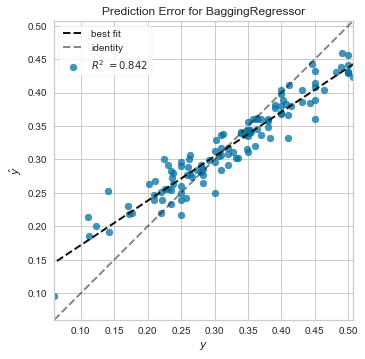

In [58]:
# Prediction Error 
plot_model(model, plot = 'error')

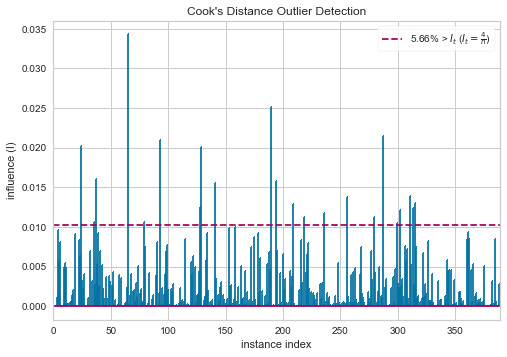

In [59]:
# Cooks Distance Plot
plot_model(model, plot='cooks')

In [60]:
# Learning Curve
#plot_model(model, plot='learning')

In [61]:
# Manifold Learning
#plot_model(model, plot='manifold')

In [62]:
# Model Hyperparameter
#plot_model(model, plot='parameter')

## 6. Blind Test

In [63]:
dfblind = pd.read_excel("BlindTest_TORIS.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind.head()

FileNotFoundError: [Errno 2] No such file or directory: 'BlindTest_TORIS.xlsx'

In [ ]:
BlindPredict = predict_model(final_blend, data=dfblind, round=2)

In [ ]:
BlindPredict

In [ ]:
a = BlindPredict['URF']
b = BlindPredict['Label']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.plot(a, a, color = 'red', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)

#plt.tight_layout()
plt.show()

In [ ]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))